In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Collecting Images
  ---
  creating a DataFrame

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!cp -r /content/drive/MyDrive/datas/data/ /content/

In [4]:
image_dir = Path('./data')

# Collecting the Lables from the Directory Name

In [5]:
file_paths = list(image_dir.glob('**/*.jpg'))  # collect all file image file_paths from the dirs
lables = list(map(lambda x: str(x).split('/')[1], file_paths))  # extract the label from the each path and store in same order

file_paths = pd.Series(file_paths, name='Filepath').astype(str) # create a pd array of filepath
lables = pd.Series(lables, name='Lables') # create a pd arr of labels

image_df = pd.concat([file_paths, lables], axis=1) # concate the file_paths and label side by side
image_df.sample(frac=1.0, random_state=1).reset_index(drop=True) # shuffle the dataframe

,Filepath,Lables
0,data/butter_chicken/2f7c51b301.jpg,butter_chicken
1,data/jalebi/dad0ed9673.jpg,jalebi
2,data/butter_chicken/6b74664f79.jpg,butter_chicken
3,data/mysore_pak/0cb6e08c3a.jpg,mysore_pak
4,data/jalebi/e40d15cdd7.jpg,jalebi
...,...,...
295,data/mysore_pak/1eb5189a9a.jpg,mysore_pak
296,data/biryani/5d7b92fe3b.jpg,biryani
297,data/gulab_jamun/0e54a8f638.jpg,gulab_jamun
298,data/mysore_pak/9e8625a45a.jpg,mysore_pak


In [118]:
image_df['Lables'].value_counts()

,count
Lables,
chapati,50
gulab_jamun,50
jalebi,50
butter_chicken,50
mysore_pak,50
biryani,50


# Train, Test, Valid Split

In [119]:
train, test = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [120]:
valid = test.copy().sample(frac=1).reset_index(drop=True)

# Type I (Transfer Model)



# Creating Generators

In [121]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

### use the Generator

In [122]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Lables',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Lables',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Lables',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 192 validated image filenames belonging to 6 classes.
Found 12 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.


# Modeling

---
### base model

> import the base model **MoblieNetV2** from tf and remove the pretrained class and use as a base model for our new model

In [123]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

In [124]:
from tensorflow.keras import layers, models

In [140]:
# more layers for precision

model = models.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,439,238 (9.30 MB)

 Trainable params: 181,254 (708.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train the Training Dataset

In [143]:
history = model.fit(
    train_images,
    epochs=100,
    validation_data=val_images,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 482ms/step - accuracy: 0.4097 - loss: 1.6049 - val_accuracy: 0.5833 - val_loss: 1.0106
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8339 - loss: 0.6465 - val_accuracy: 0.8333 - val_loss: 0.4939
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9679 - loss: 0.2225 - val_accuracy: 0.9167 - val_loss: 0.4308
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9965 - loss: 0.0797 - val_accuracy: 0.9167 - val_loss: 0.2431
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9950 - loss: 0.0339 - val_accuracy: 0.9167 - val_loss: 0.2766
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.9167 - val_loss: 0.3052
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9167 - val_loss: 0.2798
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9167 - 

# Results

In [144]:
result = model.evaluate(
    test_images,
    verbose=0
)
print(f"Accuracy: {result[1] * 100:.2f}%")
print(f"Loss: {result[0] * 100:.2f}%")

Accuracy: 96.67%
Loss: 13.18%


# Acuracy Graph

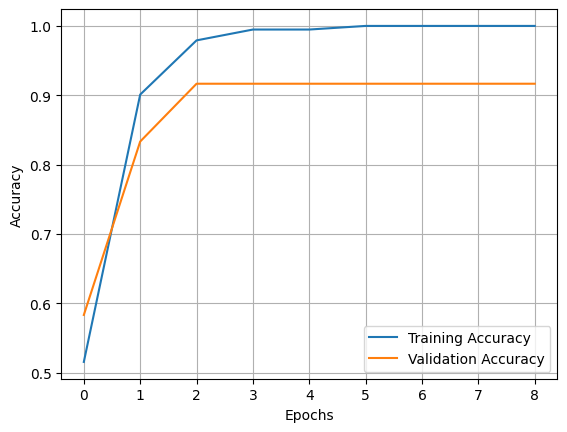

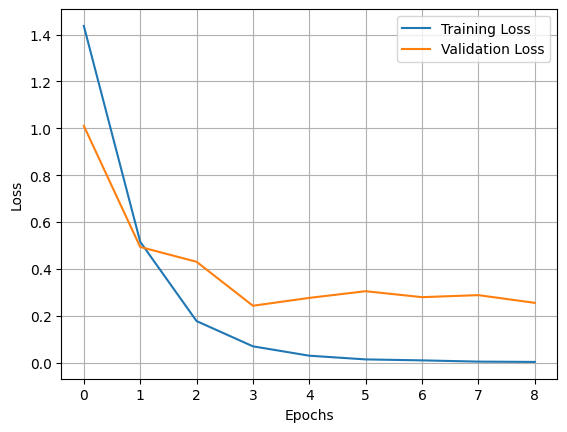

In [145]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()
  plt.show()

plot_accuracy(history)
plot_loss(history)

In [146]:
# save the model
model.save('FoodImageClassifier.h5')

# Custom images

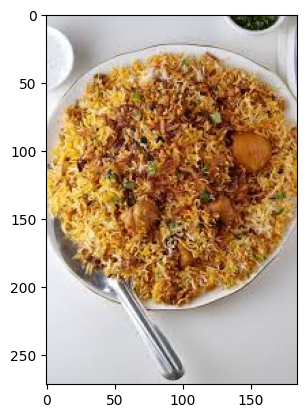

📷 briyani.jpg ➡️ Predicted: Briyani


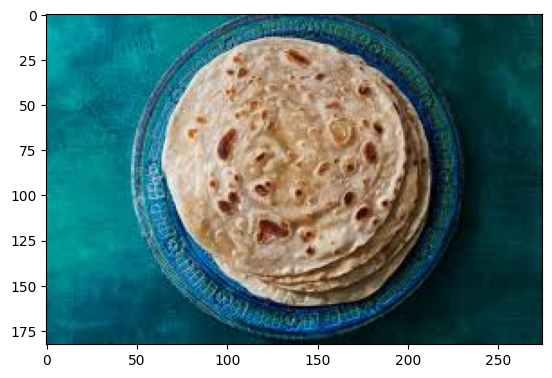

📷 chaparti.jpg ➡️ Predicted: Chaparti


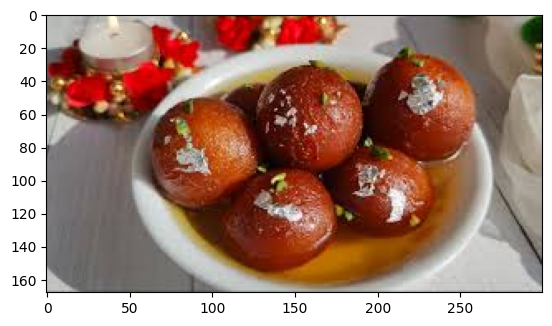

📷 gulab_jamun.jpg ➡️ Predicted: Gulab_Jamun


In [156]:
from PIL import Image
path = Path('/content/')
LABLES = ['Briyani', 'Butter_Chicken', 'Chaparti', 'Gulab_Jamun', 'Jalebi', 'Mysore_pak']
imgs = list(path.glob('*.jpg'))

def preprocess(image):
  img = Image.open(image).convert('RGB')
  img = img.resize(IMG_SIZE)
  img_arr = np.array(img) / 255.0
  img_arr = np.expand_dims(img_arr, axis=0)
  return img_arr


for i in imgs:
    name = i.name
    plt.imshow(plt.imread(i))
    plt.show()
    img_processed = preprocess(i)

    pred_class = LABLES[np.argmax(model.predict(img_processed, verbose=0))]
    print(f"📷 {name} ➡️ Predicted: {pred_class}")

